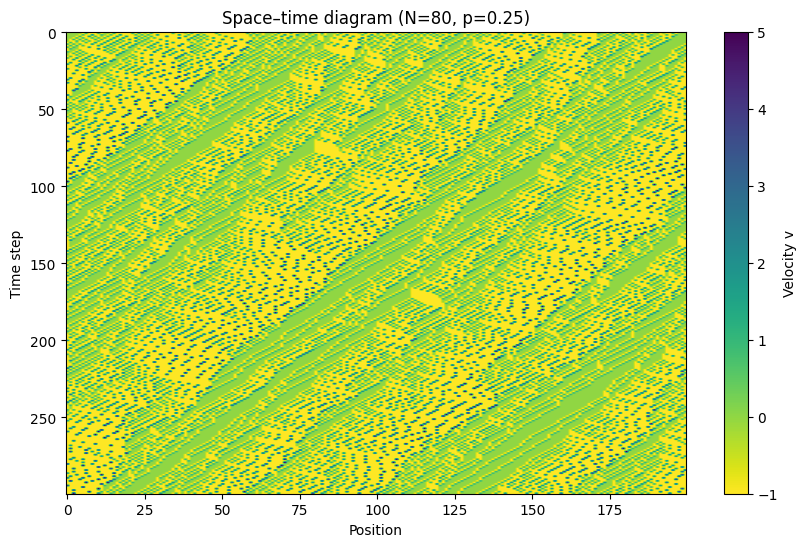

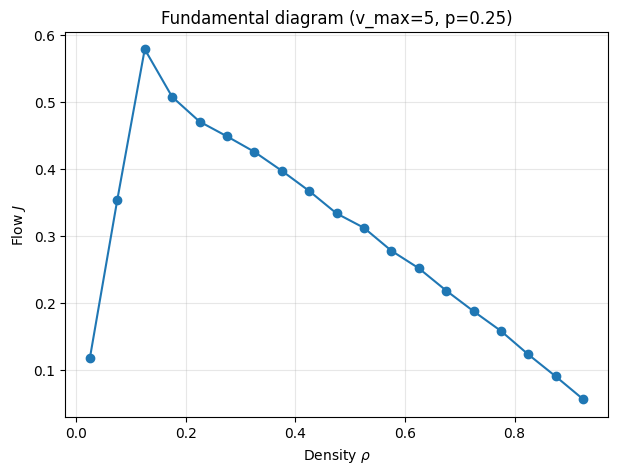

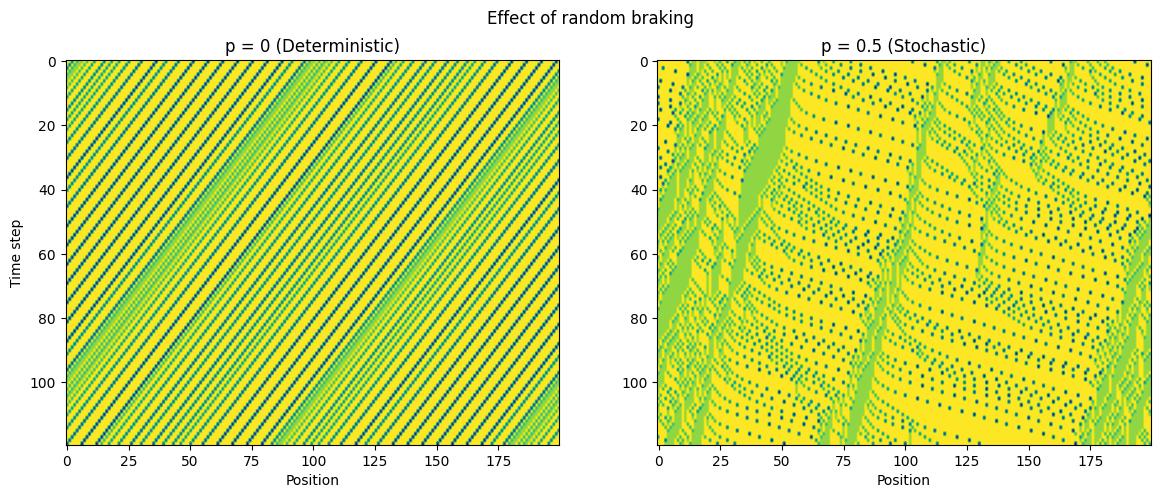

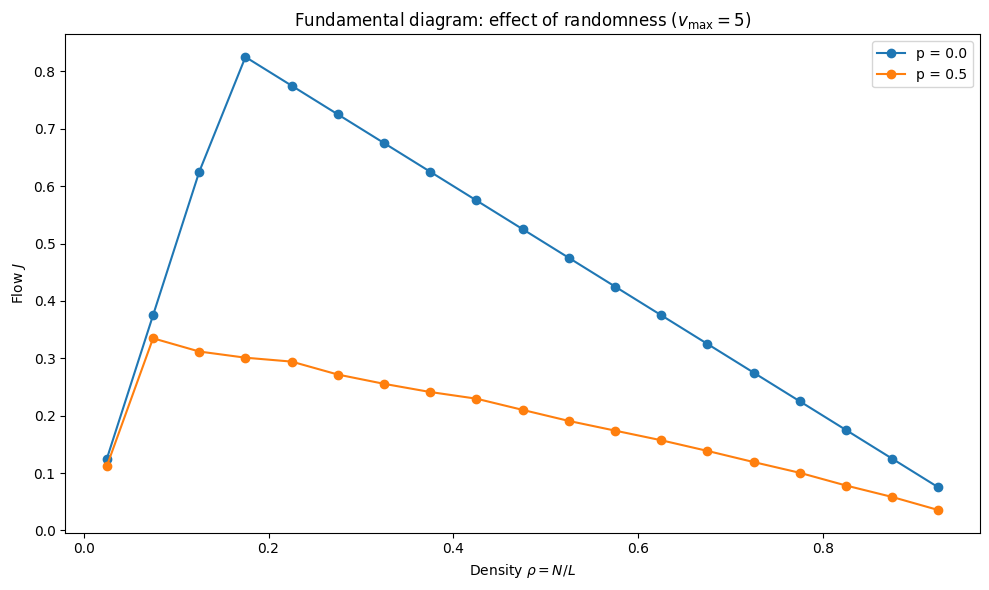

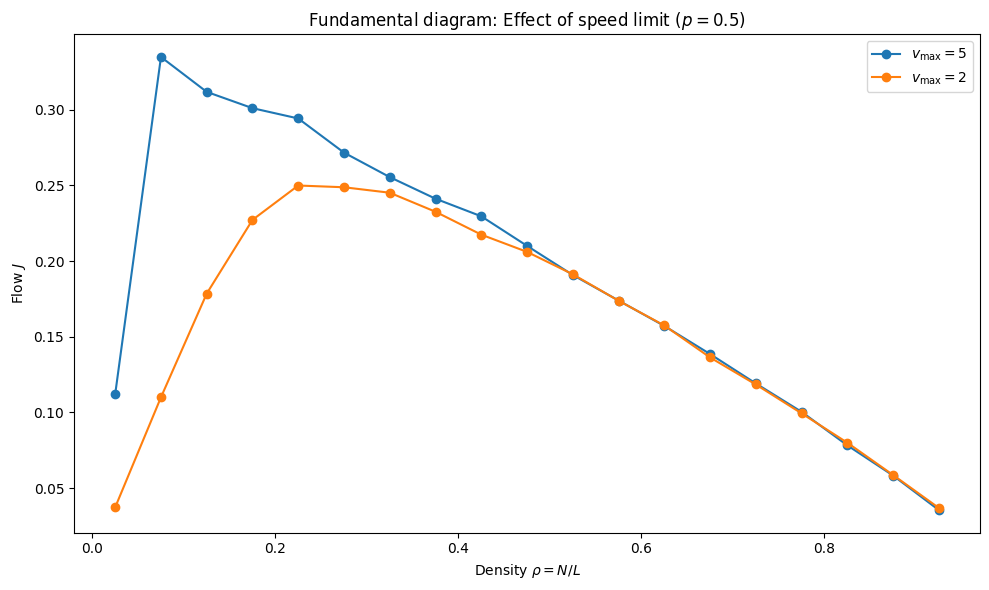

Analyzing convergence to steady-state...

Running simulation for 500 iterations...


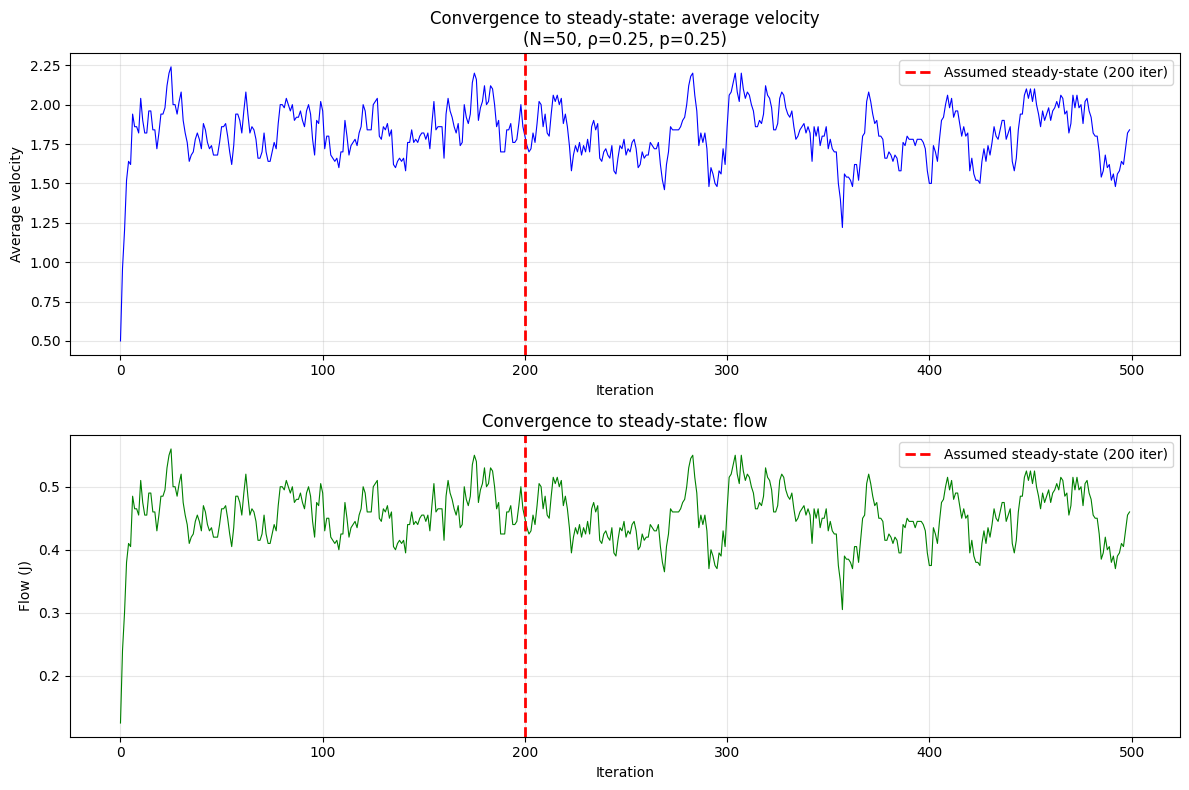


Statistics:
  First 200 iterations - Mean flow: 0.4578, Std: 0.0455
  After 200 iterations - Mean flow: 0.4514, Std: 0.0430

Difference in mean: 0.0065

System appears stable after ~52 iterations (std < 0.05 over 50-step window)


In [4]:
# Nagel-Schreckenberg Traffic Model

# Imports
import numpy as np
import matplotlib.pyplot as plt
import os

# Create images directory to save plots if it doesn't exist
os.makedirs("images", exist_ok=True)

# Core model logic
def init_road(L, N, rng):
    """Initialize road with N cars placed randomly on length L."""
    road = -np.ones(L, dtype=int)
    pos = rng.choice(L, size=N, replace=False)
    road[pos] = 0
    return road

def step(road, v_max, p, rng):
    """
    One time step of the model.
    Returns:
        new_road: The state of the road after updates
        total_distance: Total distance moved by all cars (for flow calc)
    """
    L = len(road)
    positions = np.where(road >= 0)[0]
    N = len(positions)

    new_road = -np.ones(L, dtype=int)
    total_distance = 0

    if N == 0:
        return new_road, 0

    positions.sort()
    velocities = road[positions].copy()

    for i, pos in enumerate(positions):
        v = velocities[i]
        next_pos = positions[(i + 1) % N]
        d = (next_pos - pos) % L

        if d == 0:
            d = L

        # [DEBUG] Check for collisions
        # if d <= 0:
        #     # print(f"Warning: Car at {pos} crashed into leader at {next_pos}")

        # 1. Acceleration
        if v < v_max:
            v += 1

        # 2. Deceleration (due to other cars)
        if v >= d:
            v = d - 1

        # 3. Randomization
        if v > 0 and rng.random() < p:
            v -= 1

        # 4. Movement
        new_pos = (pos + v) % L
        new_road[new_pos] = v
        total_distance += v

    return new_road, total_distance
# Simulation Wrapper
def run_spacetime(L, N, v_max, p, steps, seed=0, warmup=0):
    """Run simulation and return history for space-time plotting."""
    rng = np.random.default_rng(seed)
    road = init_road(L, N, rng)

    for _ in range(warmup):
        road, _ = step(road, v_max, p, rng)

    history = np.zeros((steps, L), dtype=int)
    for t in range(steps):
        history[t] = road
        road, _ = step(road, v_max, p, rng)

    return history
# Investigation 1 - Space-Time Diagram
# print("\n--- Running Investigation 1: Space-Time Diagram ---")

L = 200
N = 80
v_max = 5
p = 0.25

history = run_spacetime(L, N, v_max, p, steps=300)

# # print(f"Simulation finished. Output shape: {history.shape}")

plt.figure(figsize=(10, 6))
plt.imshow(history, aspect="auto", cmap="viridis_r", vmin=-1, vmax=v_max)
plt.xlabel("Position")
plt.ylabel("Time step")
plt.title(f"Space–time diagram (N={N}, p={p})")
plt.colorbar(label="Velocity v")
plt.show()
# Fundamental diagram function
def fundamental_diagram(L, v_max, p, N_values, warmup=200, measure_steps=500):
    """Calculate flow vs density."""
    rng = np.random.default_rng(1)
    densities = []
    flows = []

    # # print(f"Starting Fundamental diagram calculation for {len(N_values)} density points...")

    for i, N in enumerate(N_values):

        road = init_road(L, N, rng)

        # Warmup phase to reach steady state
        for _ in range(warmup):
            road, _ = step(road, v_max, p, rng)

        # Measurement phase
        total_distance = 0
        for _ in range(measure_steps):
            road, dist = step(road, v_max, p, rng)
            total_distance += dist

        densities.append(N / L)
        flows.append(total_distance / (L * measure_steps))

    # # print("Calculation complete.")
    return np.array(densities), np.array(flows)
# Investigation 1 (Part 2) - Plot Fundamental diagram
# # print("\n--- Running Investigation 1: Fundamental diagram ---")

N_values = range(5, 195, 10)
rho, J = fundamental_diagram(L, v_max=5, p=0.25, N_values=N_values)

plt.figure(figsize=(7, 5))
plt.plot(rho, J, "o-")
plt.xlabel(r"Density $\rho$")
plt.ylabel(r"Flow $J$")
plt.title("Fundamental diagram (v_max=5, p=0.25)")
plt.grid(True, alpha=0.3)
plt.show()
# Investigation 2 - Effect of randomness (p)
# # print("\n--- Running Investigation 2: Effect of Randomness ---")

N = 50
# print("Comparing p=0.0 vs p=0.5...")
history_p0 = run_spacetime(L, N, v_max=5, p=0.0, steps=120, warmup=200)
history_p5 = run_spacetime(L, N, v_max=5, p=0.5, steps=120, warmup=200)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(history_p0, aspect="auto", cmap="viridis_r", vmin=-1, vmax=5)
axes[0].set_title("p = 0 (Deterministic)")

axes[1].imshow(history_p5, aspect="auto", cmap="viridis_r", vmin=-1, vmax=5)
axes[1].set_title("p = 0.5 (Stochastic)")

for ax in axes:
    ax.set_xlabel("Position")
axes[0].set_ylabel("Time step")

plt.suptitle("Effect of random braking")
plt.show()

# Fundamental diagram comparison for p
# print("Calculating comparative Fundamental diagrams...")
rho0, J0 = fundamental_diagram(L, v_max=5, p=0.0, N_values=N_values)
rho5, J5 = fundamental_diagram(L, v_max=5, p=0.5, N_values=N_values)

plt.figure(figsize=(10, 6))
plt.plot(rho0, J0, "o-", label="p = 0.0")
plt.plot(rho5, J5, "o-", label="p = 0.5")
plt.xlabel(r"Density $\rho = N/L$")
plt.ylabel(r"Flow $J$")
plt.title(r"Fundamental diagram: effect of randomness ($v_{\max}=5$)")
plt.legend()
plt.tight_layout()
plt.savefig("images/investigation_2_fundamental_diagram_p0_vs_p05.png", dpi=300)
plt.show()
# Investigation 3 - Effect of Speed Limit
# print("\n--- Running Investigation 3: Effect of Speed Limit ---")

# Compare v_max = 5 vs v_max = 2
p = 0.5
# print(f"Comparing v_max=5 vs v_max=2 (p={p})...")

rho_v5, J_v5 = fundamental_diagram(L, v_max=5, p=p, N_values=N_values)
rho_v2, J_v2 = fundamental_diagram(L, v_max=2, p=p, N_values=N_values)

plt.figure(figsize=(10, 6))
plt.plot(rho_v5, J_v5, "o-", label=r"$v_{\max}=5$")
plt.plot(rho_v2, J_v2, "o-", label=r"$v_{\max}=2$")
plt.xlabel(r"Density $\rho = N/L$")
plt.ylabel(r"Flow $J$")
plt.title(r"Fundamental diagram: Effect of speed limit ($p=0.5$)")
plt.legend()
plt.tight_layout()
plt.savefig("images/investigation_3_fundamental_diagram_vmax5_vs_vmax2.png", dpi=300)
plt.show()

# print("\nAll simulations complete.")
# Steady-State Analysis

print("Analyzing convergence to steady-state...\n")

# Test parameters
L = 200
n_cars = 50
v_max = 5
p = 0.25
max_iterations = 500

# Track average velocity over time
rng = np.random.default_rng(42)
road = init_road(L, n_cars, rng)
avg_velocities = []
avg_flows = []

print("Running simulation for", max_iterations, "iterations...")
for t in range(max_iterations):
    road, total_dist = step(road, v_max, p, rng)

    # Calculate average velocity
    velocities = road[road >= 0]
    avg_v = np.mean(velocities) if len(velocities) > 0 else 0
    avg_velocities.append(avg_v)

    # Calculate flow (cars passing per unit time)
    flow = total_dist / L
    avg_flows.append(flow)

# Plot convergence
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot average velocity over time
ax1.plot(avg_velocities, color='blue', linewidth=0.8)
ax1.axvline(x=200, color='red', linestyle='--', linewidth=2, label='Assumed steady-state (200 iter)')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Average velocity")
ax1.set_title("Convergence to steady-state: average velocity\n(N=50, ρ=0.25, p=0.25)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot flow over time
ax2.plot(avg_flows, color='green', linewidth=0.8)
ax2.axvline(x=200, color='red', linestyle='--', linewidth=2, label='Assumed steady-state (200 iter)')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Flow (J)")
ax2.set_title("Convergence to steady-state: flow")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('images/steadystate_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate statistics before and after iteration 200
before_200 = avg_flows[:200]
after_200 = avg_flows[200:]

print("\nStatistics:")
print(f"  First 200 iterations - Mean flow: {np.mean(before_200):.4f}, Std: {np.std(before_200):.4f}")
print(f"  After 200 iterations - Mean flow: {np.mean(after_200):.4f}, Std: {np.std(after_200):.4f}")
print(f"\nDifference in mean: {abs(np.mean(before_200) - np.mean(after_200)):.4f}")

# Calculate when system stabilizes (when std deviation becomes small)
window = 50
for i in range(window, len(avg_flows)):
    window_std = np.std(avg_flows[i-window:i])
    if window_std < 0.05:  # Threshold for "stable"
        print(f"\nSystem appears stable after ~{i} iterations (std < 0.05 over 50-step window)")
        break


Parameters: L=200, N=80, p=0.25, ρ=0.40
Jam detection: min_cluster=10 cars, M_form=10, K_clear=10
Duration: T_warm=500, T_obs=5000

Initializing...
✓ Road initialized

Warm-up (500 steps)...
  100/500
  200/500
  300/500
  400/500
  500/500
✓ Warm-up complete

Observation (5000 steps)...
  250/5000 - jams: 0, in_jam: False, on_streak: 0, off_streak: 220
  500/5000 - jams: 0, in_jam: False, on_streak: 0, off_streak: 470
  750/5000 - jams: 1, in_jam: False, on_streak: 0, off_streak: 32
  1000/5000 - jams: 1, in_jam: False, on_streak: 0, off_streak: 36
  1250/5000 - jams: 1, in_jam: False, on_streak: 0, off_streak: 37
  1500/5000 - jams: 3, in_jam: False, on_streak: 2, off_streak: 0
  1750/5000 - jams: 3, in_jam: False, on_streak: 0, off_streak: 227
  2000/5000 - jams: 3, in_jam: False, on_streak: 0, off_streak: 477
  2250/5000 - jams: 3, in_jam: False, on_streak: 0, off_streak: 39
  2500/5000 - jams: 3, in_jam: False, on_streak: 0, off_streak: 191
  2750/5000 - jams: 4, in_jam: False, o

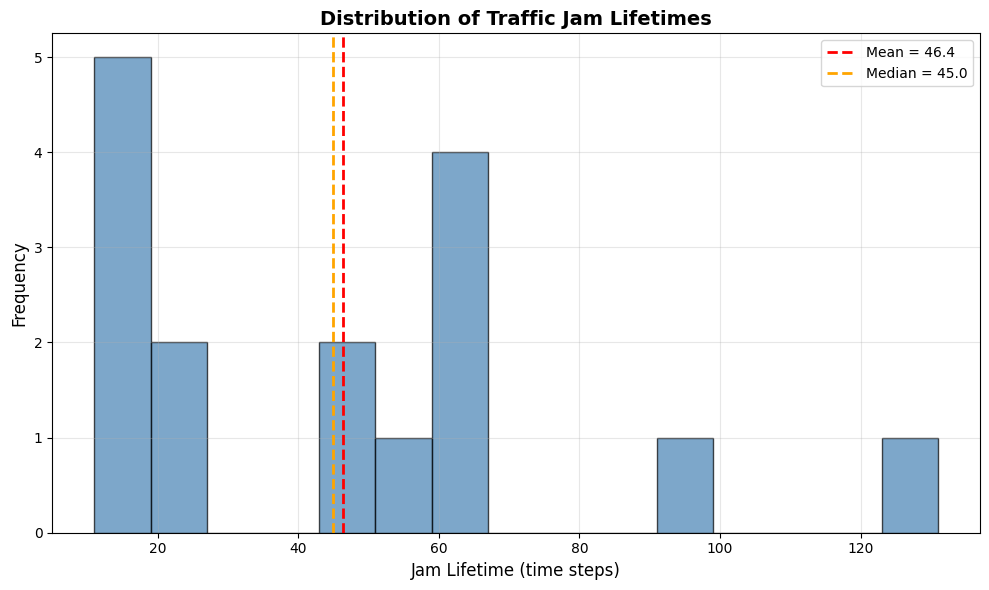

✓ Histogram saved: images/investigation_4_jam_lifetime_histogram.png


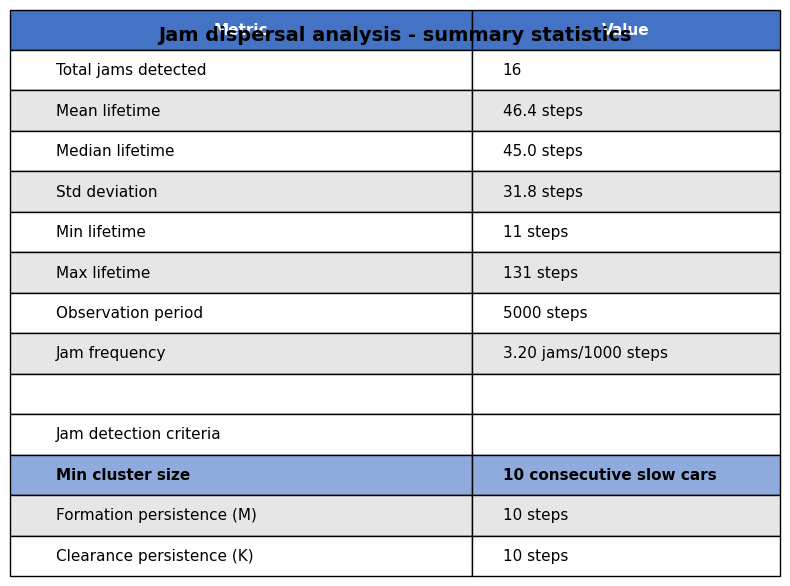

✓ Table saved: images/investigation_4_jam_statistics_table.png


In [5]:
# Traffic jam dispersal time analysis

# METHOD A

# Basic parameters
L = 200
N = 80
v_max = 5
p = 0.25

M_form = 10
K_clear = 10

T_warm = 500         # Very short warm-up
T_obs = 5000         # Short observation

print(f"\nParameters: L={L}, N={N}, p={p}, ρ={N/L:.2f}")
print(f"Jam detection: min_cluster={10} cars, M_form={M_form}, K_clear={K_clear}")
print(f"Duration: T_warm={T_warm}, T_obs={T_obs}")

# Helper function
def jam_present(road, min_cluster_size=10):
    """Detect if there are localized jam clusters (contiguous slow cars)"""
    slow_mask = (road >= 0) & (road <= 1)  # Slow/stopped cars
    cluster_size = 0

    for i in range(len(road)):
        if slow_mask[i]:
            cluster_size += 1
            if cluster_size >= min_cluster_size:
                return True  # Found a jam cluster
        else:
            cluster_size = 0  # Reset counter

    return False  # No jam clusters found

# Initialize
print("\nInitializing...")
rng = np.random.default_rng(42)
road = init_road(L, N, rng)
print("✓ Road initialized")

# Warm-up
print(f"\nWarm-up ({T_warm} steps)...")
for t in range(T_warm):
    road, _ = step(road, v_max, p, rng)
    if (t + 1) % 100 == 0:
        print(f"  {t + 1}/{T_warm}")
print("✓ Warm-up complete")

# Observation
print(f"\nObservation ({T_obs} steps)...")
jam_on_streak = 0
jam_off_streak = 0
in_jam = False
t_form = None
jam_lifetimes = []

for t in range(T_obs):
    is_jam_present = jam_present(road, min_cluster_size=10)

    if is_jam_present:
        jam_on_streak += 1
        jam_off_streak = 0
    else:
        jam_off_streak += 1
        jam_on_streak = 0

    if (not in_jam) and (jam_on_streak == M_form):
        in_jam = True
        t_form = t

    if in_jam and (jam_off_streak == K_clear):
        t_clear = t
        tau = t_clear - t_form
        jam_lifetimes.append(tau)
        in_jam = False
        t_form = None

    road, _ = step(road, v_max, p, rng)

    if (t + 1) % 250 == 0:
        print(f"  {t + 1}/{T_obs} - jams: {len(jam_lifetimes)}, in_jam: {in_jam}, on_streak: {jam_on_streak}, off_streak: {jam_off_streak}")

print("\n" + "="*70)
print(f"RESULT: {len(jam_lifetimes)} jams detected")
if len(jam_lifetimes) > 0:
    print(f"Mean lifetime: {np.mean(jam_lifetimes):.1f} steps")
    print(f"Median lifetime: {np.median(jam_lifetimes):.1f} steps")
    print(f"Std deviation: {np.std(jam_lifetimes):.1f} steps")
    print(f"Min/Max: {np.min(jam_lifetimes)} / {np.max(jam_lifetimes)} steps")
print("="*70)

# Visualization
if len(jam_lifetimes) > 0:
    # Figure 1: Histogram of jam lifetimes
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.hist(jam_lifetimes, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(np.mean(jam_lifetimes), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(jam_lifetimes):.1f}')
    ax1.axvline(np.median(jam_lifetimes), color='orange', linestyle='--', linewidth=2, label=f'Median = {np.median(jam_lifetimes):.1f}')
    ax1.set_xlabel('Jam Lifetime (time steps)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Traffic Jam Lifetimes', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('images/investigation_4_jam_lifetime_histogram.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Histogram saved: images/investigation_4_jam_lifetime_histogram.png")

    # Figure 2: Summary statistics table
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    stats_data = [
        ['Total jams detected', f'{len(jam_lifetimes)}'],
        ['Mean lifetime', f'{np.mean(jam_lifetimes):.1f} steps'],
        ['Median lifetime', f'{np.median(jam_lifetimes):.1f} steps'],
        ['Std deviation', f'{np.std(jam_lifetimes):.1f} steps'],
        ['Min lifetime', f'{np.min(jam_lifetimes)} steps'],
        ['Max lifetime', f'{np.max(jam_lifetimes)} steps'],
        ['Observation period', f'{T_obs} steps'],
        ['Jam frequency', f'{len(jam_lifetimes)/T_obs*1000:.2f} jams/1000 steps'],
        ['', ''],
        ['Jam detection criteria', ''],
        ['Min cluster size', f'{10} consecutive slow cars'],
        ['Formation persistence (M)', f'{M_form} steps'],
        ['Clearance persistence (K)', f'{K_clear} steps']
    ]

    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(cellText=stats_data, colLabels=['Metric', 'Value'],
                      cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)

    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Style section header (row 11: 'Jam Detection Criteria')
    for j in range(2):
        table[(11, j)].set_facecolor('#8FAADC')
        table[(11, j)].set_text_props(weight='bold')

    # Alternate row colors (skip empty row 10 and section header row 11)
    for i in range(1, len(stats_data) + 1):
        if i == 10 or i == 11:  # Skip empty row and section header
            continue
        for j in range(2):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E7E6E6')

    ax2.set_title('Jam dispersal analysis - summary statistics', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('images/investigation_4_jam_statistics_table.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Table saved: images/investigation_4_jam_statistics_table.png")



Parameters: L=200, N=80, p=0.25, ρ=0.40
Jam detection: min_cluster=10 cars, M_form=10, K_clear=10
Monte Carlo: R=30 runs, T_warm=500, T_max=5000

Running Monte Carlo simulations...
  Completed 10/30 runs
  Completed 20/30 runs
  Completed 30/30 runs

MONTE CARLO RESULTS
Total runs: 30
Runs with cleared jams: 30
Runs with persistent jams: 1 (3.3%)

Total jam episodes detected: 331

Mean jam lifetime (all episodes): 38.9 steps
Median jam lifetime: 26.0 steps
Std deviation: 36.9 steps
Min/Max: 10 / 241 steps

Mean of per-run averages: 37.3 steps
Std of per-run averages: 11.2 steps


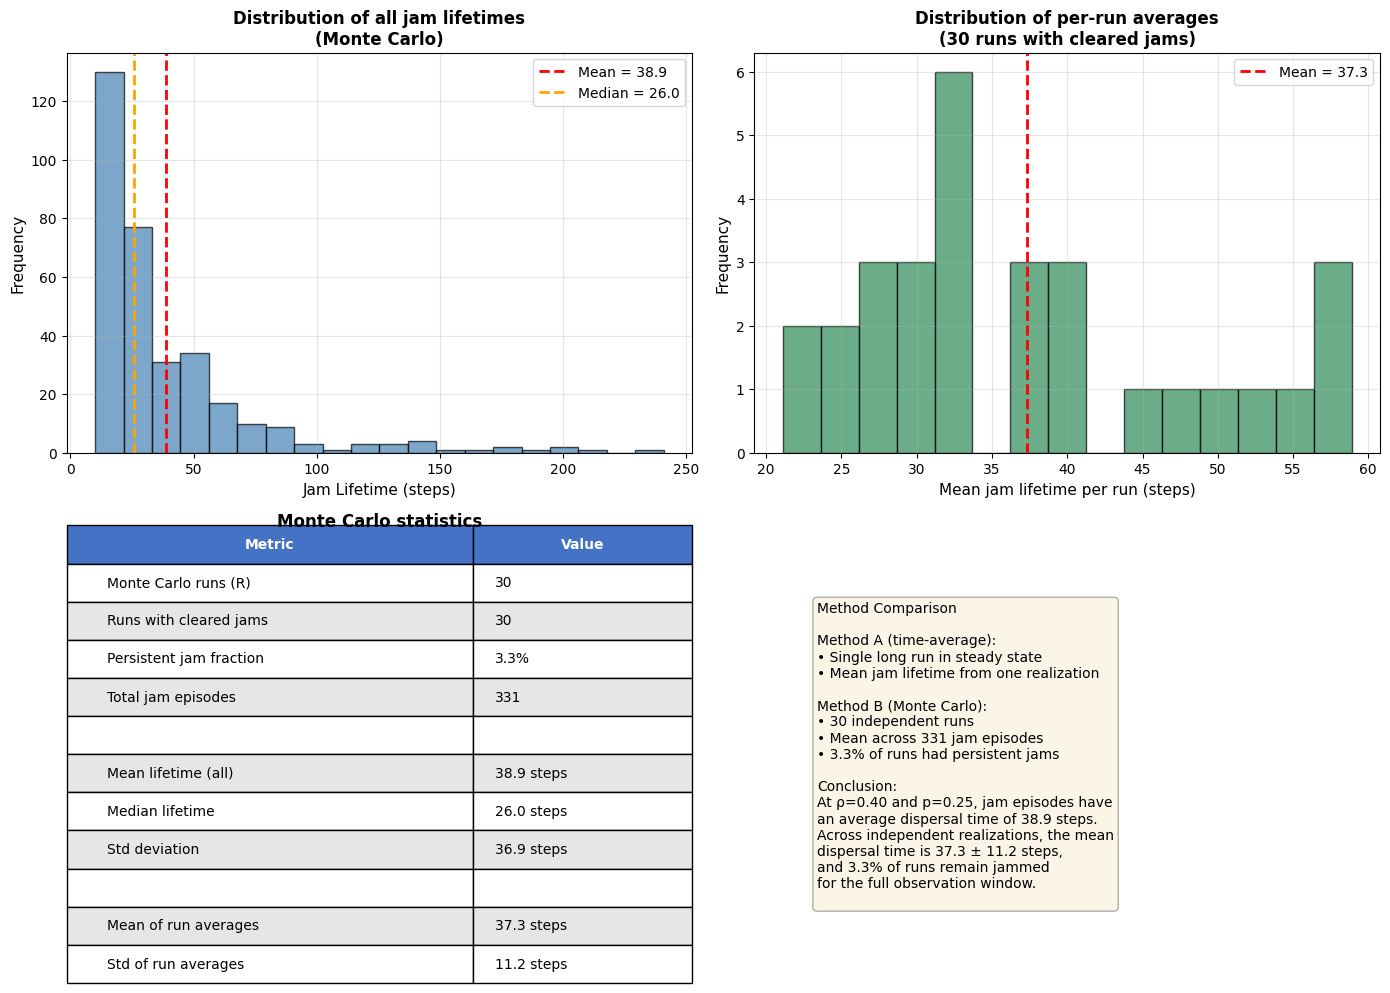


✓ Combined figure saved: images/investigation_4_monte_carlo_analysis.png
✓ Saved: images/investigation_4_mc_all_lifetimes.png
✓ Saved: images/investigation_4_mc_per_run_averages.png


In [6]:

# Jam dispersal analysis - Method B - Monte Carlo analysis

# Parameters (same as Method A)
L = 200
N = 80
v_max = 5
p = 0.25
min_cluster_size = 10
M_form = 10
K_clear = 10
T_warm = 500
T_max = 5000  # Maximum observation time per run
R = 30  # Number of runs

print(f"\nParameters: L={L}, N={N}, p={p}, ρ={N/L:.2f}")
print(f"Jam detection: min_cluster={min_cluster_size} cars, M_form={M_form}, K_clear={K_clear}")
print(f"Monte Carlo: R={R} runs, T_warm={T_warm}, T_max={T_max}")

# Helper function (same as Method A)
def jam_present(road, min_cluster_size=10):
    """Detect if there are localized jam clusters (contiguous slow cars)"""
    slow_mask = (road >= 0) & (road <= 1)
    cluster_size = 0
    for i in range(len(road)):
        if slow_mask[i]:
            cluster_size += 1
            if cluster_size >= min_cluster_size:
                return True
        else:
            cluster_size = 0
    return False

def simulate_one_run(seed, L, N, v_max, p, min_cluster_size, M_form, K_clear, T_warm, T_max):
    """Run one simulation and return (jam_lifetimes, persistent_flag)"""
    rng = np.random.default_rng(seed)
    road = init_road(L, N, rng)

    # Warm-up
    for t in range(T_warm):
        road, _ = step(road, v_max, p, rng)

    # Observation
    jam_on_streak = 0
    jam_off_streak = 0
    in_jam = False
    t_form = None
    jam_lifetimes = []

    for t in range(T_max):
        is_jam_present = jam_present(road, min_cluster_size)

        if is_jam_present:
            jam_on_streak += 1
            jam_off_streak = 0
        else:
            jam_off_streak += 1
            jam_on_streak = 0

        if (not in_jam) and (jam_on_streak == M_form):
            in_jam = True
            t_form = t

        if in_jam and (jam_off_streak == K_clear):
            t_clear = t
            tau = t_clear - t_form
            jam_lifetimes.append(tau)
            in_jam = False
            t_form = None

        road, _ = step(road, v_max, p, rng)

    # Check if jam persisted through entire observation
    persistent_flag = (in_jam and t_form is not None)

    return jam_lifetimes, persistent_flag

def run_monte_carlo(R, L, N, v_max, p, min_cluster_size, M_form, K_clear, T_warm, T_max):
    """Run Monte Carlo simulation over R runs"""
    all_lifetimes = []  # All jam lifetimes from all runs
    taus_per_run = []  # Mean lifetime per run (only runs with cleared jams)
    persistent_count = 0

    print("\nRunning Monte Carlo simulations...")
    for r in range(R):
        seed = 1000 + r  # Unique seed for each run
        jam_lifetimes, persistent = simulate_one_run(
            seed, L, N, v_max, p, min_cluster_size, M_form, K_clear, T_warm, T_max
        )

        if persistent:
            persistent_count += 1

        if len(jam_lifetimes) > 0:
            all_lifetimes.extend(jam_lifetimes)
            taus_per_run.append(np.mean(jam_lifetimes))

        if (r + 1) % 10 == 0:
            print(f"  Completed {r + 1}/{R} runs")

    return all_lifetimes, taus_per_run, persistent_count

# Run Monte Carlo
all_lifetimes, taus_per_run, persistent_count = run_monte_carlo(
    R, L, N, v_max, p, min_cluster_size, M_form, K_clear, T_warm, T_max
)

# Compute statistics
persistent_fraction = persistent_count / R
cleared_runs = len(taus_per_run)

print("\n" + "="*70)
print("MONTE CARLO RESULTS")
print("="*70)
print(f"Total runs: {R}")
print(f"Runs with cleared jams: {cleared_runs}")
print(f"Runs with persistent jams: {persistent_count} ({persistent_fraction*100:.1f}%)")
print(f"\nTotal jam episodes detected: {len(all_lifetimes)}")

if len(all_lifetimes) > 0:
    print(f"\nMean jam lifetime (all episodes): {np.mean(all_lifetimes):.1f} steps")
    print(f"Median jam lifetime: {np.median(all_lifetimes):.1f} steps")
    print(f"Std deviation: {np.std(all_lifetimes):.1f} steps")
    print(f"Min/Max: {np.min(all_lifetimes)} / {np.max(all_lifetimes)} steps")

if len(taus_per_run) > 0:
    print(f"\nMean of per-run averages: {np.mean(taus_per_run):.1f} steps")
    print(f"Std of per-run averages: {np.std(taus_per_run):.1f} steps")

print("="*70)

# Visualization
if len(all_lifetimes) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Histogram of all jam lifetimes
    ax1 = axes[0, 0]
    ax1.hist(all_lifetimes, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(np.mean(all_lifetimes), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(all_lifetimes):.1f}')
    ax1.axvline(np.median(all_lifetimes), color='orange', linestyle='--', linewidth=2,
                label=f'Median = {np.median(all_lifetimes):.1f}')
    ax1.set_xlabel('Jam Lifetime (steps)', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Distribution of all jam lifetimes\n(Monte Carlo)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Per-run mean lifetimes
    ax2 = axes[0, 1]
    if len(taus_per_run) > 0:
        ax2.hist(taus_per_run, bins=15, edgecolor='black', alpha=0.7, color='seagreen')
        ax2.axvline(np.mean(taus_per_run), color='red', linestyle='--', linewidth=2,
                    label=f'Mean = {np.mean(taus_per_run):.1f}')
        ax2.set_xlabel('Mean jam lifetime per run (steps)', fontsize=11)
        ax2.set_ylabel('Frequency', fontsize=11)
        ax2.set_title(f'Distribution of per-run averages\n({cleared_runs} runs with cleared jams)',
                      fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # 3. Summary statistics table
    ax3 = axes[1, 0]
    stats_data = [
        ['Monte Carlo runs (R)', f'{R}'],
        ['Runs with cleared jams', f'{cleared_runs}'],
        ['Persistent jam fraction', f'{persistent_fraction*100:.1f}%'],
        ['Total jam episodes', f'{len(all_lifetimes)}'],
        ['', ''],
        ['Mean lifetime (all)', f'{np.mean(all_lifetimes):.1f} steps'],
        ['Median lifetime', f'{np.median(all_lifetimes):.1f} steps'],
        ['Std deviation', f'{np.std(all_lifetimes):.1f} steps'],
    ]

    if len(taus_per_run) > 0:
        stats_data.extend([
            ['', ''],
            ['Mean of run averages', f'{np.mean(taus_per_run):.1f} steps'],
            ['Std of run averages', f'{np.std(taus_per_run):.1f} steps']
        ])

    ax3.axis('tight')
    ax3.axis('off')
    table = ax3.table(cellText=stats_data, colLabels=['Metric', 'Value'],
                      cellLoc='left', loc='center', colWidths=[0.65, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    for i in range(2):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    for i in range(1, len(stats_data) + 1):
        for j in range(2):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E7E6E6')

    ax3.set_title('Monte Carlo statistics', fontsize=12, fontweight='bold', pad=20)

    # 4. Comparison text box
    ax4 = axes[1, 1]
    ax4.axis('off')

    comparison_text = f"""Method Comparison

Method A (time-average):
• Single long run in steady state
• Mean jam lifetime from one realization

Method B (Monte Carlo):
• {R} independent runs
• Mean across {len(all_lifetimes)} jam episodes
• {persistent_fraction*100:.1f}% of runs had persistent jams

Conclusion:
At ρ={N/L:.2f} and p={p}, jam episodes have
an average dispersal time of {np.mean(all_lifetimes):.1f} steps.
Across independent realizations, the mean
dispersal time is {np.mean(taus_per_run):.1f} ± {np.std(taus_per_run):.1f} steps,
and {persistent_fraction*100:.1f}% of runs remain jammed
for the full observation window.
"""

    ax4.text(0.1, 0.5, comparison_text, fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    # Save combined figure
    plt.tight_layout()
    plt.savefig('images/investigation_4_monte_carlo_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✓ Combined figure saved: images/investigation_4_monte_carlo_analysis.png")

    # Save individual subplots as separate files
    # 1. All lifetimes histogram
    fig1, ax = plt.subplots(figsize=(10, 6))
    ax.hist(all_lifetimes, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.mean(all_lifetimes), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(all_lifetimes):.1f}')
    ax.axvline(np.median(all_lifetimes), color='orange', linestyle='--', linewidth=2,
                label=f'Median = {np.median(all_lifetimes):.1f}')
    ax.set_xlabel('Jam lifetime (steps)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of all jam lifetimes (Monte Carlo)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('images/investigation_4_mc_all_lifetimes.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("✓ Saved: images/investigation_4_mc_all_lifetimes.png")

    # 2. Per-run averages histogram
    if len(taus_per_run) > 0:
        fig2, ax = plt.subplots(figsize=(10, 6))
        ax.hist(taus_per_run, bins=15, edgecolor='black', alpha=0.7, color='seagreen')
        ax.axvline(np.mean(taus_per_run), color='red', linestyle='--', linewidth=2,
                    label=f'Mean = {np.mean(taus_per_run):.1f}')
        ax.set_xlabel('Mean jam lifetime per run (steps)', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Distribution of per-run averages ({cleared_runs} runs with cleared jams)',
                      fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('images/investigation_4_mc_per_run_averages.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Saved: images/investigation_4_mc_per_run_averages.png")
